# Clone my driving behavior

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D
from keras.optimizers import Adam
from keras import backend as K
from livelossplot import PlotLossesKeras

In [2]:
user = !whoami
user = user[0]

In [3]:
IMAGE_SHAPE = (160, 320, 3)
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'

## Load images and measurements

In [4]:
def load_images_and_measurements(image_set_directory):
    driving_log = (
        pd.read_csv(
            f'./my-videos/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    raw_images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    flipped_images = np.flip(raw_images, axis=2)

    images = np.vstack([raw_images, flipped_images])
    
    raw_measurements = driving_log['steering_angle']
    measurements_flipped = - raw_measurements

    measurements = np.hstack([raw_measurements, measurements_flipped])
    
    return images, measurements

In [5]:
def load_image_sets(image_set_names):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [6]:
%%time
images, measurements = load_image_sets(['first_drives', '3_backward_rounds'])
print(f'Number of samples: {measurements.shape[0]}')

Number of samples: 9626
CPU times: user 7.8 s, sys: 1.21 s, total: 9.01 s
Wall time: 18.5 s


## Define model

In [34]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE),
    Lambda(lambda x: x / 255.0 - 0.5),
    Conv2D(20, (5, 5), activation='relu'),
    Conv2D(20, (5, 5), activation='relu'),
    MaxPooling2D(),
    Conv2D(50, (5, 5), activation='relu'),
    Conv2D(50, (5, 5), activation='relu'),
    MaxPooling2D(),
    Conv2D(50, (3, 5), activation='relu'),
    Conv2D(50, (3, 5), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(120),
    Dense(84),
    Dense(1)
])

model.compile(loss='mse', optimizer=Adam(lr=0.0001))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_5 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 316, 20)       1520      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 57, 312, 20)       10020     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 156, 20)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 152, 50)       25050     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 148, 50)       62550     
__________

## Train model

In [36]:
model.fit(
    images, 
    measurements, 
    epochs=1,
    validation_split=0.2, 
    shuffle=True)

Train on 7700 samples, validate on 1926 samples
Epoch 1/1
7700/7700 [==============================] - 31s 4ms/step - loss: 0.0054 - val_loss: 0.0022


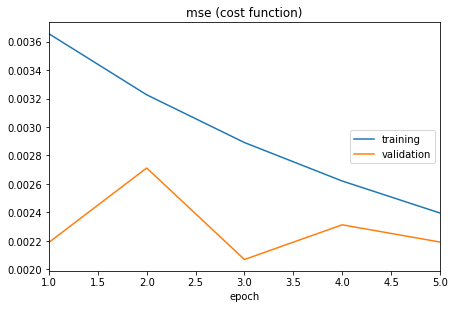

mse (cost function):
training   (min:    0.002, max:    0.004, cur:    0.002)
validation (min:    0.002, max:    0.003, cur:    0.002)


In [37]:
model.fit(
    images, 
    measurements, 
    epochs=5,
    callbacks=[PlotLossesKeras()],
    validation_split=0.2, 
    shuffle=True)

In [38]:
model.save('./models/model_lenet_variant_3_for_back_rounds_data.h5a')

## Visualize output of convolution layers

In [39]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name or 'cropping2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

In [40]:
def plot_layer_channels(layer, name):
    number_of_channels = layer.shape[2]
    square_size = int(np.ceil(np.sqrt(number_of_channels)))

    fig, axes = plt.subplots(nrows=square_size, ncols=square_size, figsize=(20,20))
    for idx, image in enumerate(layer.transpose(2, 0, 1)):
        row = idx // square_size
        col = idx % square_size
        axes[row, col].axis('off')
        axes[row, col].imshow(image, cmap='gray', aspect='auto')

    for idx in [i for i in range(square_size ** 2) if i >= number_of_channels]:
        row = idx // square_size
        col = idx % square_size
        fig.delaxes(axes[row, col])
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f'Channels of layer {name}', fontsize=18)
    plt.subplots_adjust(wspace=.05, hspace=.05)
    plt.show()

In [41]:
def plot_layers(input_image, evaluation_functions):
    layer_outputs = evaluation_functions([[input_image], 0.])
    
    plt.title('Input image')
    plt.imshow(input_image)
    plt.show()
    
    plt.title('Cropped image')
    plt.imshow(layer_outputs[0][0].astype('uint8'))
    plt.show()
    
    for layer, name in zip(layer_outputs[1:], layer_names[1:]):
        plot_layer_channels(layer[0], name)

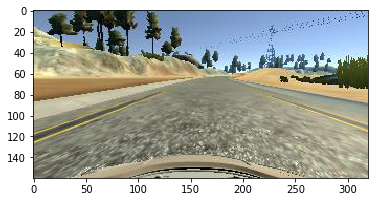

In [45]:
test_image = images[5000]
plt.imshow(test_image)
plt.show()

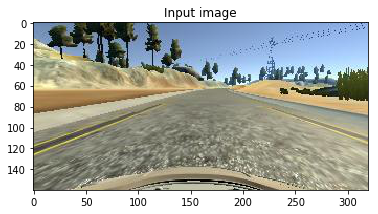

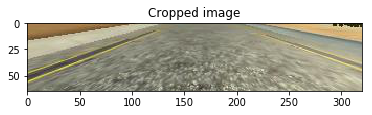

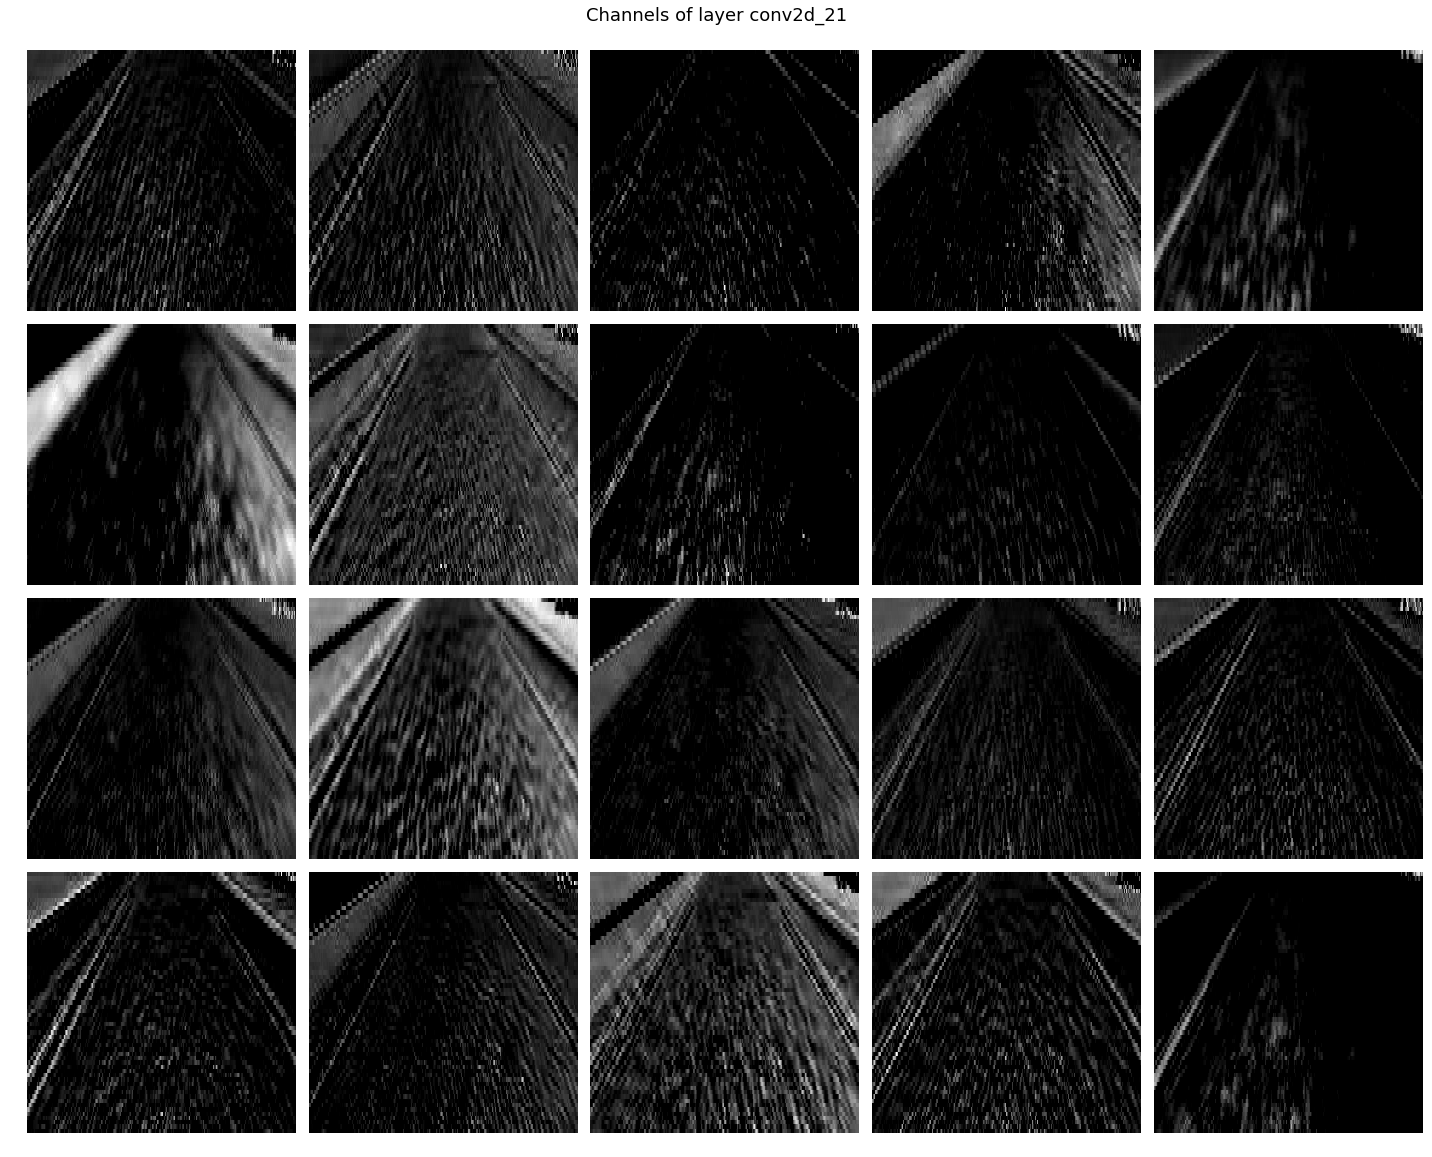

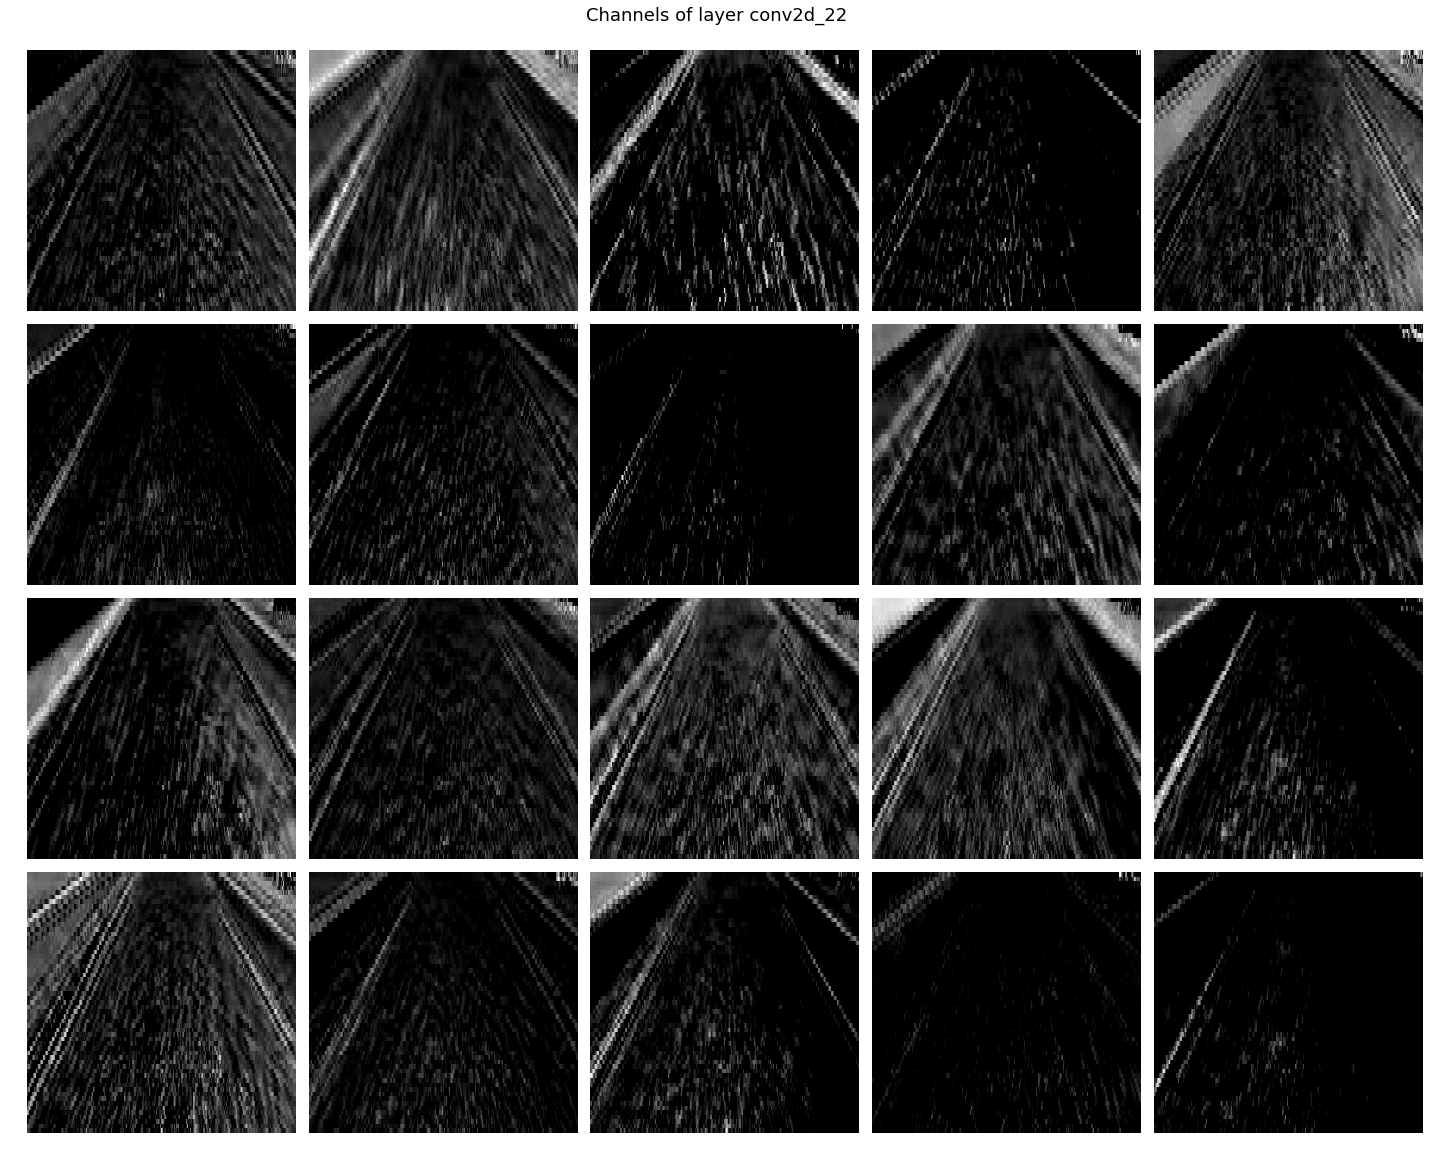

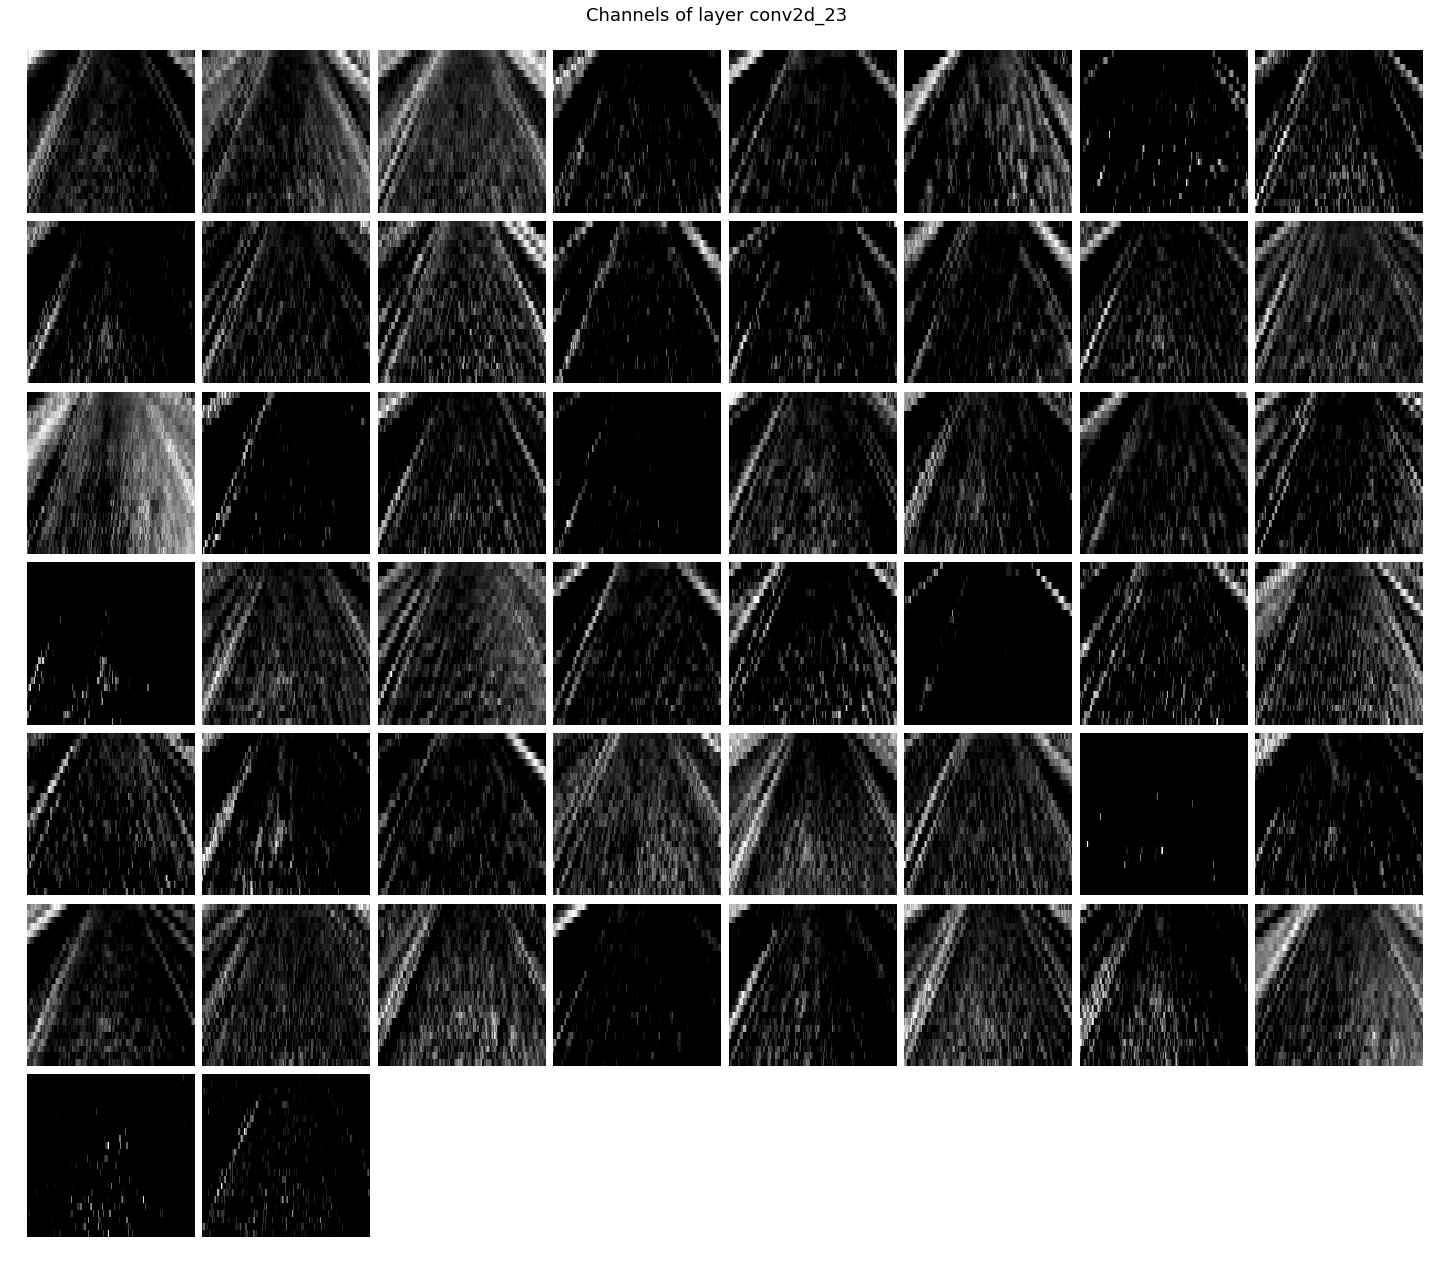

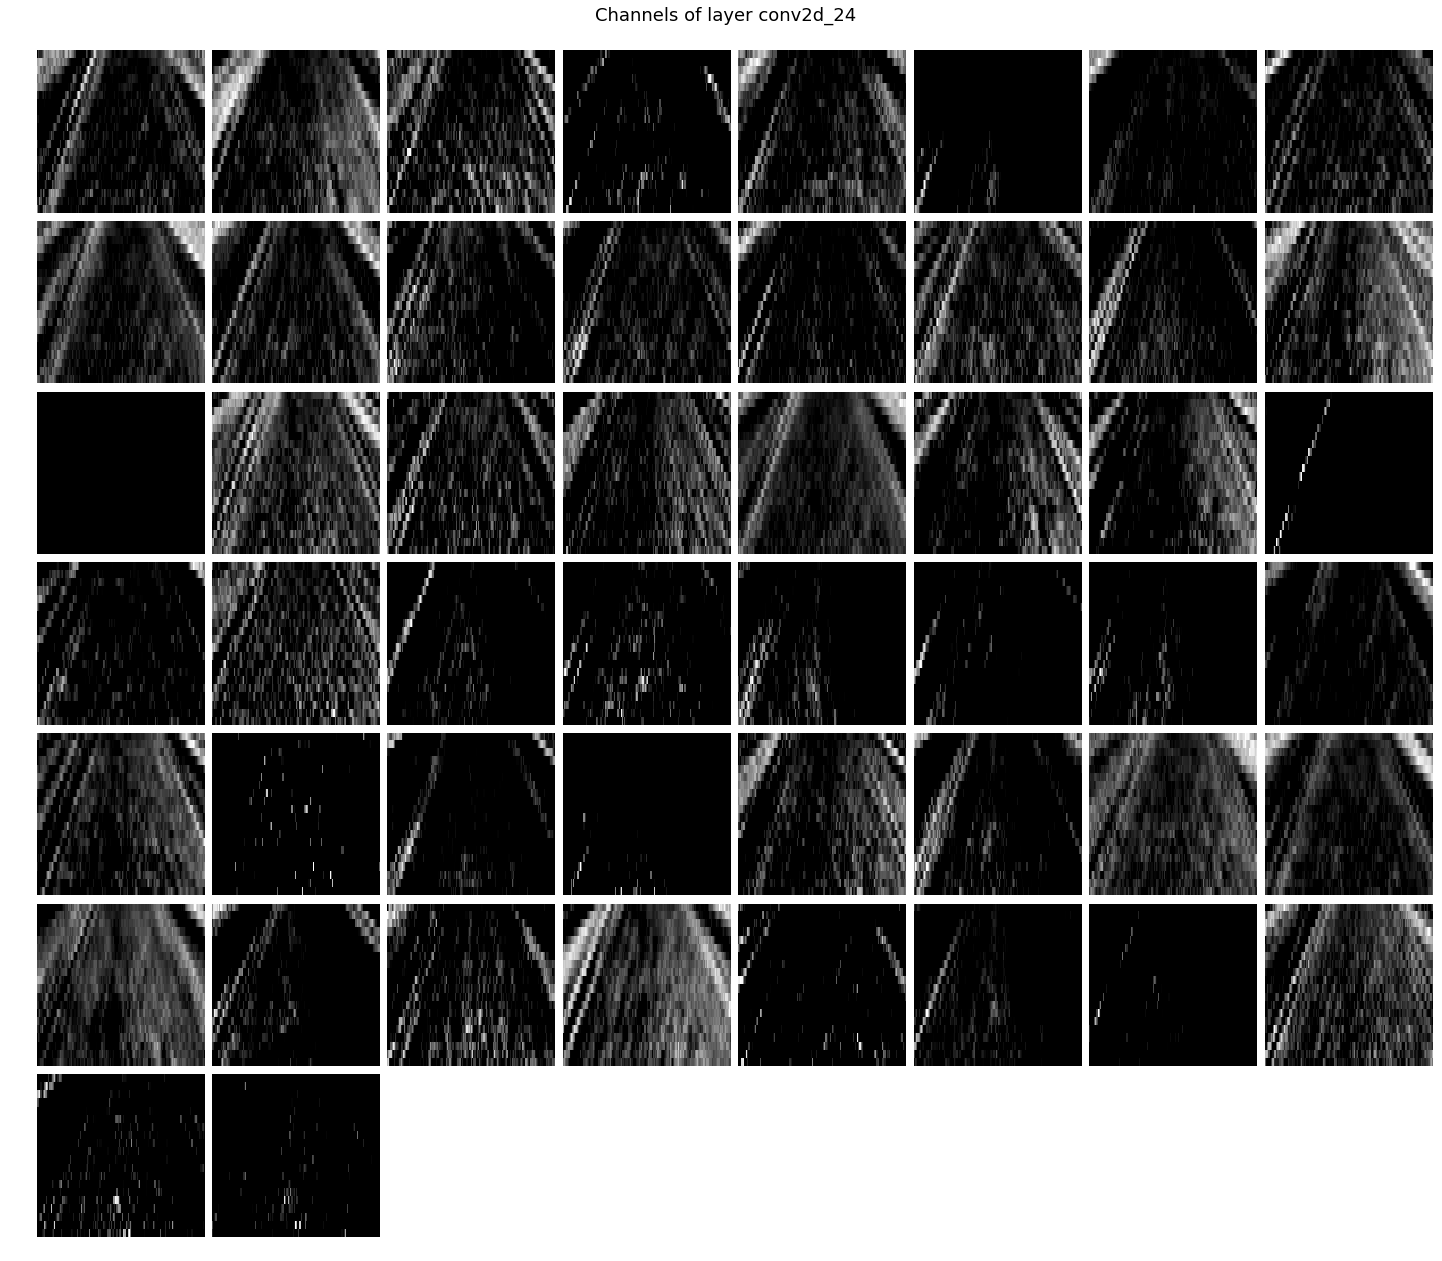

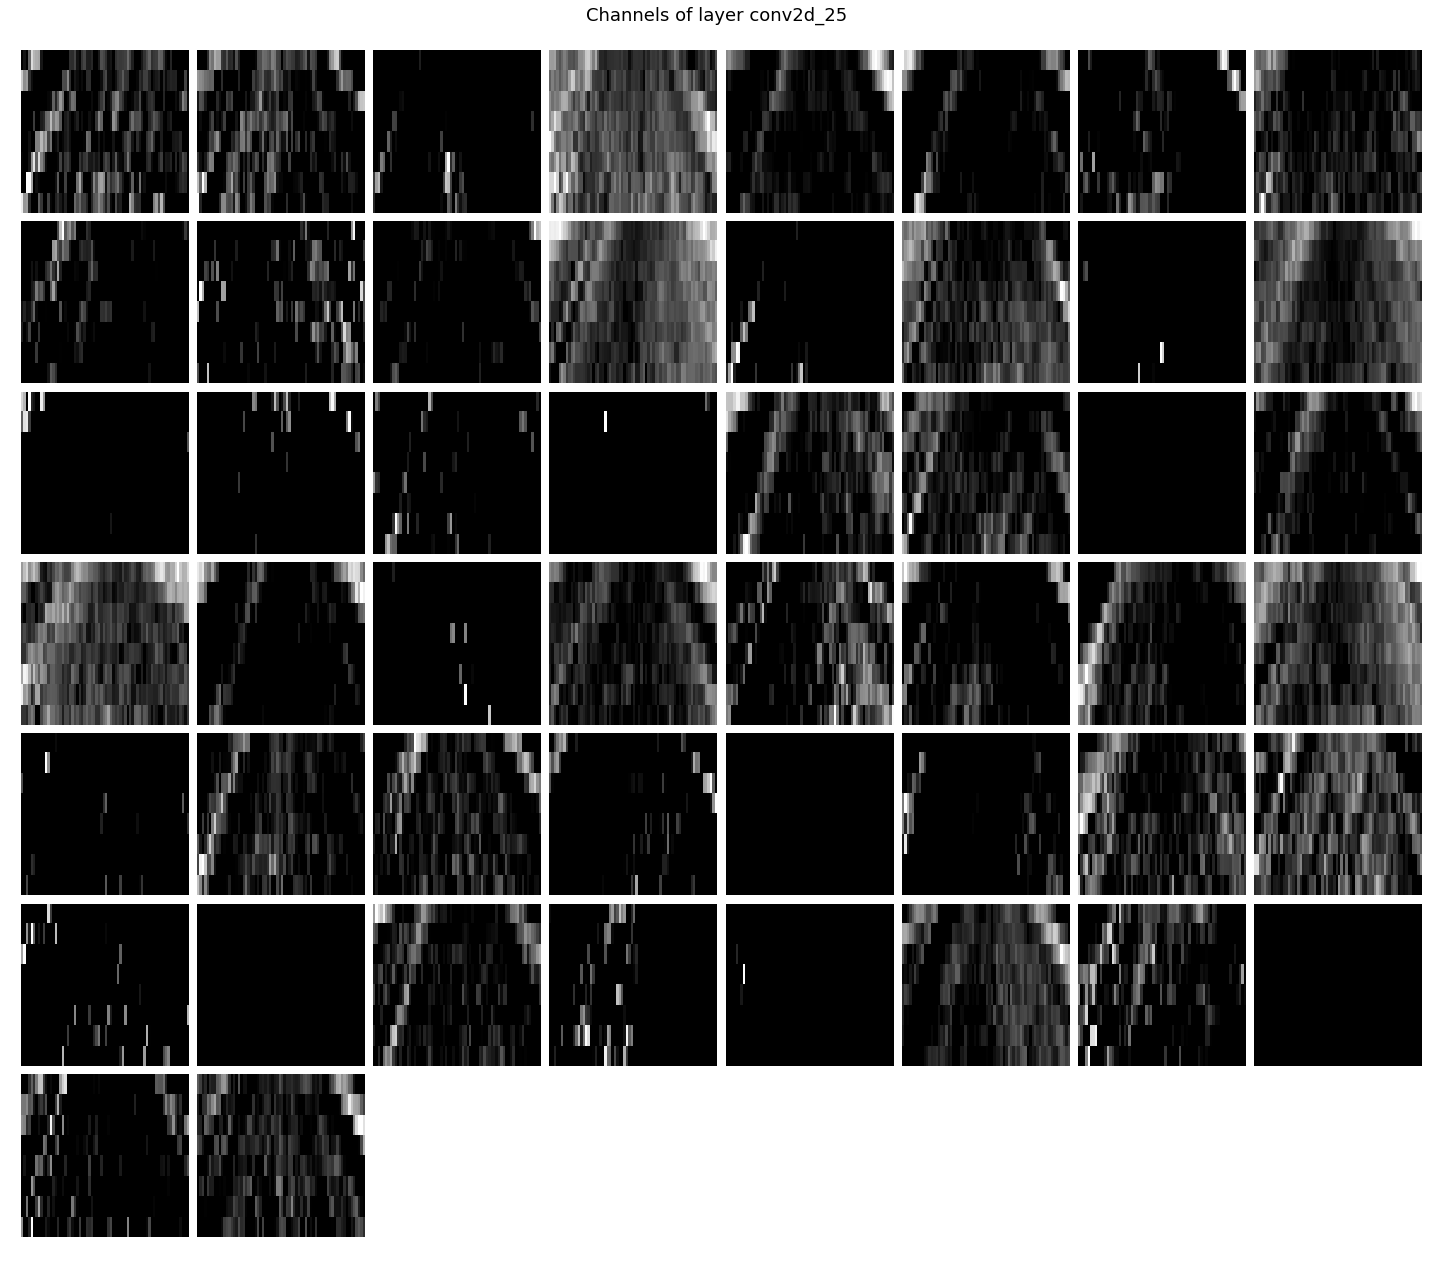

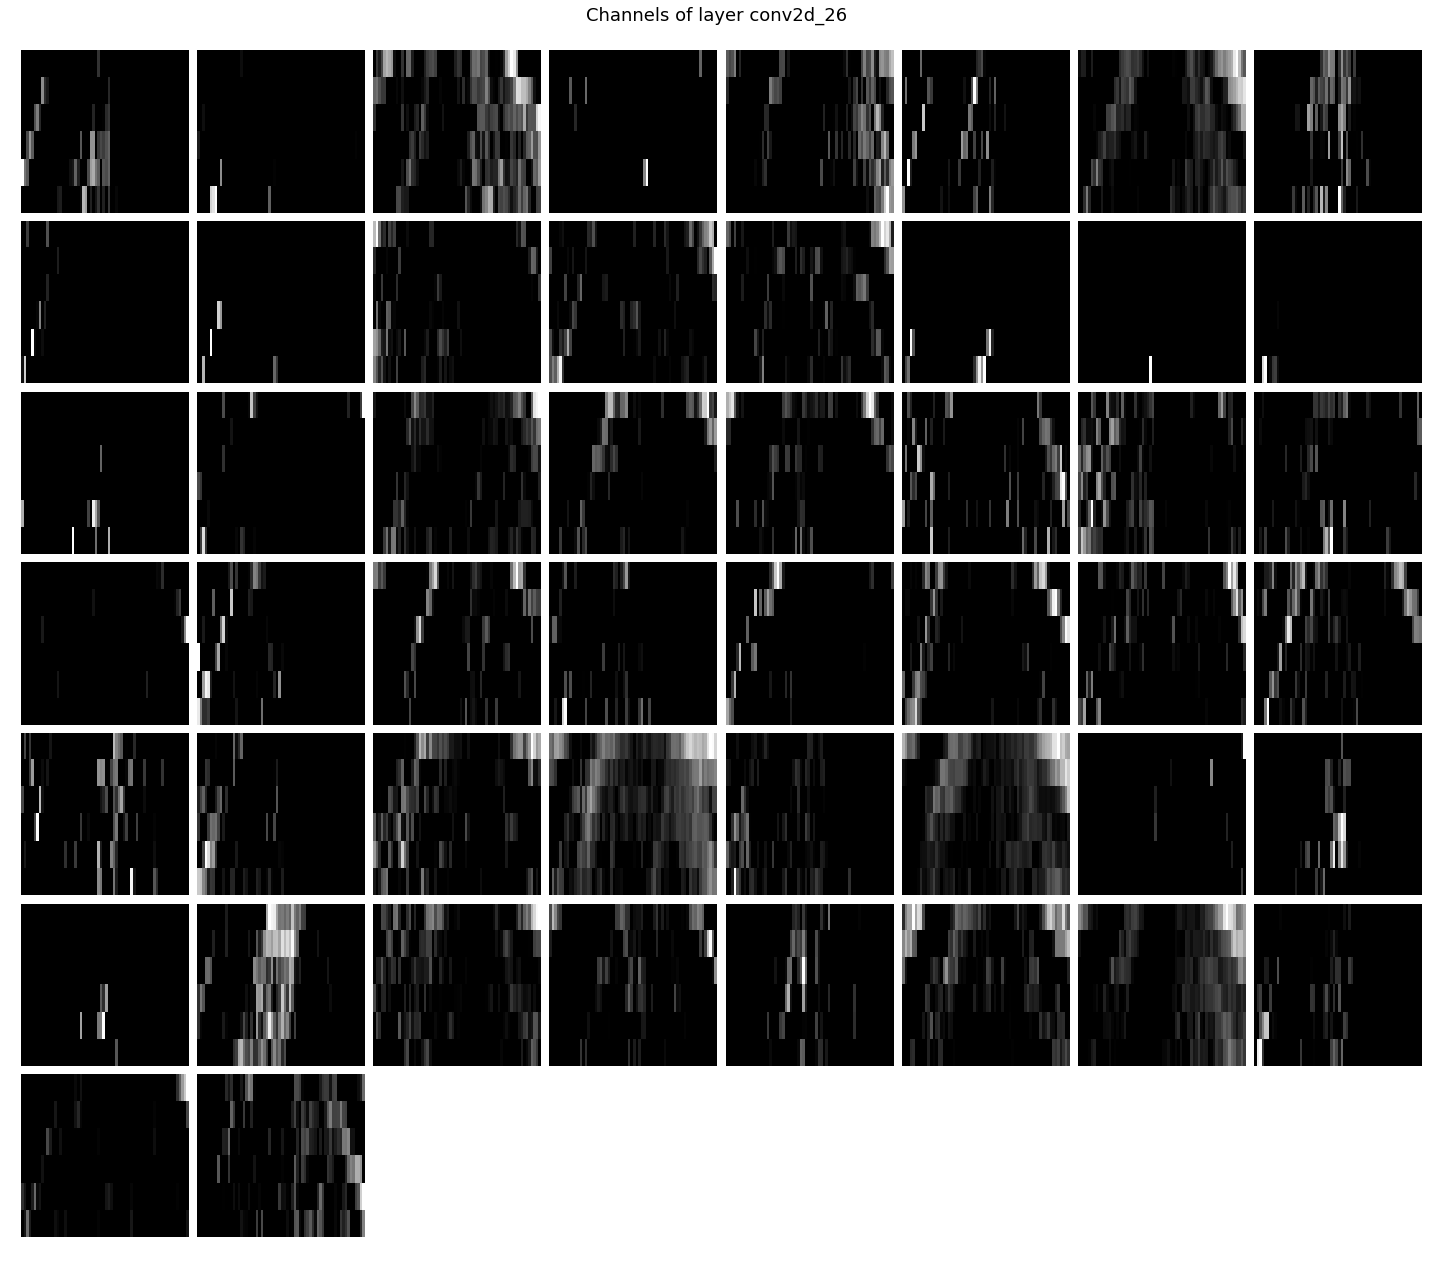

In [46]:
plot_layers(test_image, evaluation_functions)